# Reading in WRF data into Xarray

* In this example the variable data and coordinates are split between files
* An in-memory netcdf file is created and fed into wrf-python (https://wrf-python.readthedocs.io/en/latest/)
* Once the WRF data is in an Xarray DataArray there are additional tools you can use to assess the data (http://xarray.pydata.org/en/stable/)

In [2]:
from netCDF4 import Dataset
import wrf
import xarray as xr
import numpy as np

import matplotlib
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import matplotlib.pyplot as plt


In [3]:
my_var   = 'SPDUV10MEAN'
root_dir = '/data/fiss_aic/WRF/runA_2010'

In [4]:
#################################
### Get variables and dimensions
#################################
### source
src = Dataset(root_dir+'/wrfxtrm_d02') 
### destination (tmp netCDF file stored in memory)
dst = Dataset("dst_tmp.nc", "w", format="NETCDF4", diskless=True)


dst.setncatts(src.__dict__)

### copy all dimensions from src to dst
for name, dimension in src.dimensions.items():
    dst.createDimension(name, 
            len(dimension) if not dimension.isunlimited() else None)

### copy chosen variables (my_var) from src to dst
### we also need to extract time from this nc file
get_all_vars = [my_var] + ['Times']
for name in get_all_vars:
    variable = src.variables[name]
    dst.createVariable(name, variable.datatype, variable.dimensions)
    dst.variables[name][:] = src.variables[name][:]
    dst[name].setncatts(src[name].__dict__)

#################################
### And spatial coordinates
#################################
coord_file = Dataset(root_dir+'/wrfout_d02_2010-03-18_00:00:00')
coords = ['XLAT', 'XLONG']
for name in coords:
    variable = coord_file.variables[name]
    dst.createVariable(name, variable.datatype, variable.dimensions)
    
    ### create coord array with the correct shape (i.e. lat x lon for all times)
    correct_shape_arr = np.zeros( dst.variables[name].shape )
    correct_shape_arr[:,:,:] = coord_file.variables[name][0,:,:]
    
    dst.variables[name][:] = correct_shape_arr
    dst[name].setncatts(coord_file[name].__dict__)


In [5]:
#################################
### Create WRF Xarray DataArray
#################################
da = wrf.getvar(dst, my_var, timeidx=wrf.ALL_TIMES)

### close in-memory netCDF Dataset
dst.close()

In [6]:
da

<xarray.DataArray 'SPDUV10MEAN' (Time: 380, south_north: 201, west_east: 147)>
array([[[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ]],

       [[ 8.39886 ,  8.444758, ..., 14.510515, 14.117192],
        [ 8.461802,  8.429548, ..., 14.581321, 14.274388],
        ...,
        [ 8.573125,  8.489813, ...,  7.011718,  6.957026],
        [ 8.61706 ,  8.525856, ...,  6.904287,  6.832181]],

       ...,

       [[ 4.510708,  5.035859, ...,  8.76118 ,  8.800939],
        [ 4.781097,  5.058285, ...,  8.620676,  8.777421],
        ...,
        [ 4.429987,  4.134745, ...,  6.34187 ,  6.242588],
        [ 4.387664,  4.140485, ...,  6.29833 ,  6.344316]],

       [[ 7.957785,  8.12633 , ..., 10.177639, 10.159102],
        [ 7.729648,  7.760167, ..., 10.030386, 10.143531],
        ...,
        [ 7.964691,  7.9

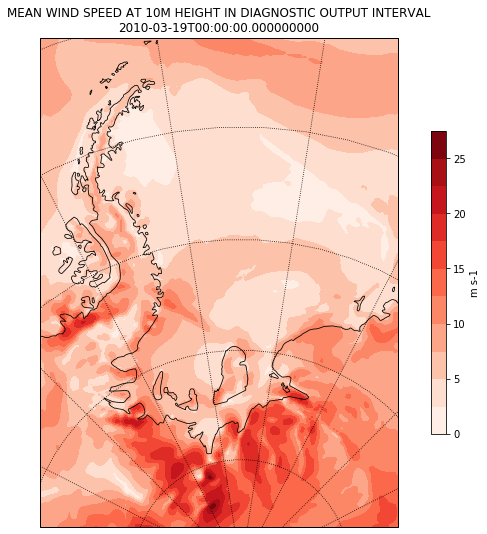

In [7]:
#################################
### Plotting
#################################

# select 2nd timestep
da1 = da.isel(Time=1)

# Get the latitude and longitude points
lats, lons = wrf.latlon_coords(da1)

# Get the cartopy mapping object
cart_proj = wrf.get_cartopy(da1)

# Create a figure
fig = plt.figure(figsize=(12,9))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
ax.coastlines('50m', linewidth=0.8)

# Plot contours
plt.contourf(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(da1), 10, 
                transform=crs.PlateCarree(), cmap=get_cmap("Reds"))

# Add a color bar
cbar = plt.colorbar(ax=ax, shrink=.62)
cbar.set_label(da1.units)

# Set the map limits.  Not really necessary, but used for demonstration.
ax.set_xlim(wrf.cartopy_xlim(da))
ax.set_ylim(wrf.cartopy_ylim(da))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title(da.description+'\n'+str(da1.Time.values))

print('')